In [1]:
import pandas as pd
import numpy as np
import time 

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier


from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn import tree
import seaborn as sns
import shap
from sklearn.model_selection import ShuffleSplit

In [2]:
train = pd.read_parquet('train.parquet')
test = pd.read_parquet('test.parquet')

In [3]:
test.global_category.value_counts()

CAMERA             6313
AUDIO              5755
HOME AUTOMATION    5346
Name: global_category, dtype: int64

In [4]:
train.global_category.value_counts()

HOME AUTOMATION    11985
AUDIO              11765
CAMERA             11020
Name: global_category, dtype: int64

In [5]:
#Eliminamos las siguientes columnas, ya que de momento no las vamos a usar
train = train.drop(columns = ['device','interaction_type','command'])
#Eliminamos las siguientes columnas, ya que de momento no las vamos a usar
test = test.drop(columns = ['device','interaction_type','command'])

In [6]:
x_train, y_train = train.drop(columns=['global_category']), train['global_category']
x_test, y_test = test.drop(columns=['global_category']), test['global_category']

In [7]:
print('66.63% Train y 33.37% Test: ')
print(f'Train : {train.shape}')
print(f'Test : {test.shape}')

66.63% Train y 33.37% Test: 
Train : (34770, 42)
Test : (17414, 42)


In [14]:
#Para no usar cross validation(Tarda mucho y ofrece peores resultados)
cv = ShuffleSplit(n_splits=1, test_size=0.2, random_state=1)

# RANDOM FOREST

## Sin hiperparámetros:

In [8]:
RF_model = RandomForestClassifier()

In [9]:
start = time.time()
RF_model.fit(x_train, y_train)
stop = time.time()

In [10]:
print(f"RF execution time: {stop - start}s")
print(f'Train accuracy : {RF_model.score(x_train, y_train): .3f}')
print(f'Test accuracy : {RF_model.score(x_test, y_test): .3f}')

RF execution time: 4.447997093200684s
Train accuracy :  1.000
Test accuracy :  0.800


### Matriz de confusión:

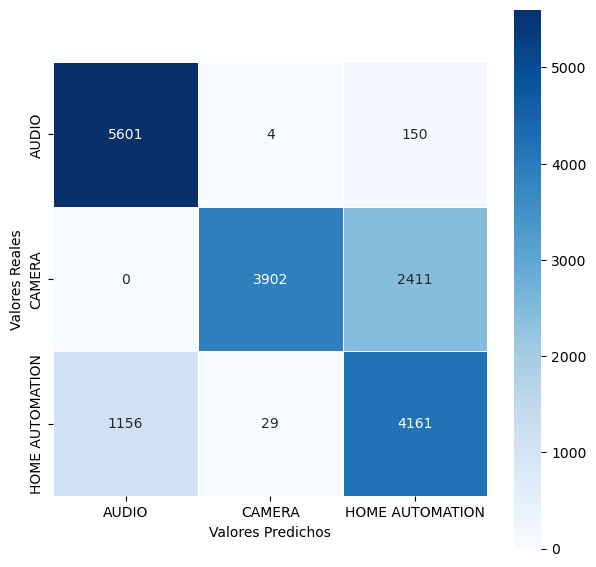

In [13]:
y_pred_RF1 = RF_model.predict(x_test)
cm = metrics.confusion_matrix(y_test, y_pred_RF1)
class_names = ['AUDIO', 'CAMERA', 'HOME AUTOMATION']

sns.heatmap(cm, annot = True, fmt = '0.0f', linewidth=0.5, xticklabels=class_names, 
            yticklabels=class_names, square = True, cmap='Blues')

fig = plt.gcf()
fig.set_size_inches(7, 7)

plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
plt.show()

### F1_Score, recall y precision:

In [14]:
print(metrics.classification_report(y_test, y_pred_RF1))

                 precision    recall  f1-score   support

          AUDIO       0.83      0.97      0.90      5755
         CAMERA       0.99      0.62      0.76      6313
HOME AUTOMATION       0.62      0.78      0.69      5346

       accuracy                           0.78     17414
      macro avg       0.81      0.79      0.78     17414
   weighted avg       0.82      0.78      0.78     17414



# Definición de todos los hiperparámetros:

In [71]:
# Número de árboles
n_estimators = [int(x) for x in np.linspace(start=10, stop=150, num=15)]
# Criterio de creación de los árboles. Es la función que mide la calidad de las "split".
criterion = ["gini", "entropy"]
#Para fijar la profundidad máxima de los árboles
max_depth = [int(x) for x in np.linspace(start=1, stop=10, num=10)] 
# Número de características a tener en cuenta para cada árbol
max_features = ['auto', 'sqrt', 'log2', None]
# Mínimo número de muestras que se requieren para dividir un nodo
min_samples_split = [int(x) for x in np.linspace(start=1, stop=10, num=10)]
# Mínimo número de muestras que se requieren en cada hoja
min_samples_leaf = [int(x) for x in np.linspace(start=1, stop=10, num=10)]
# True -> Muestreo Aleatorio
# False -> Se utiliza el dataset entero para construir cada árbol
bootstrap = [True, False]
# (Out of the bag) Datos que NO vamos a usar para el muestreo. Al activar esto, se usarán dichos datos para testear los árboles
# Solo disponible si bootstrap es True
oob_score = [True, False]
# True -> Reutiliza la solución de la llamada anterior para el fit y para agregar más estimadores al conjunto.
# False -> Realiza un bosque completamente nuevo.
warm_start = [True, False]
# Controla tanto la aleatoriedad del bootstrap (si bootstrap = true),
# como el muestreo de las propiedades a tener en cuenta al buscar la mejor división de cada nodo,
random_state = [int(x) for x in np.linspace(start=1, stop=50, num=50)]
# Pesos asociados a las clases
class_weight = ['balanced', 'balanced_subsample']

# Porcentaje de los datos que vamos a muestrear (si bootstrap es True)
max_samples = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

In [72]:
param_grid = {'n_estimators': n_estimators,
              'criterion': criterion,
              'max_features': max_features,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}

print(param_grid)

{'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150], 'criterion': ['gini', 'entropy'], 'max_features': ['auto', 'sqrt', 'log2', None], 'min_samples_split': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'bootstrap': [True, False]}


# Primera elección con RandomSearchCV:

In [23]:
RF_RandomGrid1 = RandomizedSearchCV(estimator = RF_model,
                                   param_distributions = param_grid,
                                   cv = 5, verbose=2, n_jobs = 4)

In [24]:
start = time.time()
RF_RandomGrid1.fit(x_train, y_train)
stop = time.time()

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [25]:
RF_RandomGrid1.best_params_

{'n_estimators': 120,
 'min_samples_split': 3,
 'min_samples_leaf': 5,
 'max_features': 'auto',
 'criterion': 'gini',
 'bootstrap': False}

In [26]:
print(f"RandomizedSearch RF time: {stop - start}s")
print(f'Train accuracy : {RF_RandomGrid1.score(x_train, y_train): .3f}')
print(f'Test accuracy : {RF_RandomGrid1.score(x_test, y_test): .3f}')

RandomizedSearch RF time: 148.3711986541748s
Train accuracy :  1.000
Test accuracy :  0.831


In [33]:
RF_model2 = RandomForestClassifier(n_estimators=120,
                                   criterion='gini',
                                   min_samples_split=3, 
                                   min_samples_leaf=5,
                                   max_features='auto')

start = time.time()
RF_model2.fit(x_train, y_train)
stop = time.time()

In [34]:
print(f"RF training time: {stop - start}s")
print(f'Train accuracy : {RF_model2.score(x_train, y_train): .3f}')
print(f'Test accuracy : {RF_model2.score(x_test, y_test): .3f}')

RF training time: 7.742918252944946s
Train accuracy :  1.000
Test accuracy :  0.789


## Matriz de confusión:

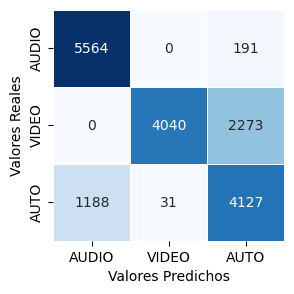

In [37]:
y_pred_RF1 = RF_model2.predict(x_test)
cm = metrics.confusion_matrix(y_test, y_pred_RF1)
class_names = ['AUDIO', 'VIDEO', 'AUTO']

sns.heatmap(cm, annot = True, fmt = '0.0f', linewidth=0.5, xticklabels=class_names, 
            yticklabels=class_names, square = True, cmap='Blues', cbar = False)

fig = plt.gcf()
fig.set_size_inches(3, 3)

plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
plt.show()

In [38]:
print(metrics.classification_report(y_test, y_pred_RF1))

                 precision    recall  f1-score   support

          AUDIO       0.82      0.97      0.89      5755
         CAMERA       0.99      0.64      0.78      6313
HOME AUTOMATION       0.63      0.77      0.69      5346

       accuracy                           0.79     17414
      macro avg       0.81      0.79      0.79     17414
   weighted avg       0.82      0.79      0.79     17414



# Segunda elección con RandomSearchCV:

In [130]:
#Con los nuevos parámetros, sale error de que hay demasiadas operaciones en curso
param_grid2 = {'n_estimators': n_estimators,
              'max_depth': max_depth,
              'criterion': criterion,
              'max_features': max_features,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf}

RF_RandomGrid2 = RandomizedSearchCV(estimator = RF_model,
                                   param_distributions = param_grid2,
                                   cv = 5, verbose=2, n_jobs = 4)

start = time.time()
RF_RandomGrid2.fit(x_train, y_train)
stop = time.time()

Fitting 5 folds for each of 10 candidates, totalling 50 fits



10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\boii_\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\boii_\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "C:\Users\boii_\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\boii_\anaconda3\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\boii_\anaco

In [131]:
print(f"RandomizedSearch RF time: {stop - start}s")
print(f'Train accuracy : {RF_RandomGrid2.score(x_train, y_train): .3f}')
print(f'Test accuracy : {RF_RandomGrid2.score(x_test, y_test): .3f}')

RandomizedSearch RF time: 65.9891631603241s
Train accuracy :  0.998
Test accuracy :  0.904


In [132]:
RF_RandomGrid2.best_params_

{'n_estimators': 80,
 'min_samples_split': 10,
 'min_samples_leaf': 8,
 'max_features': 'auto',
 'max_depth': 10,
 'criterion': 'entropy'}

In [139]:
RF_model5 = RandomForestClassifier(n_estimators=80,
                                   criterion='entropy',
                                   max_depth = 10,
                                   min_samples_split=10, 
                                   min_samples_leaf=8,
                                   max_features='auto')
start = time.time()
RF_model5.fit(x_train, y_train)
stop = time.time()

In [140]:
print(f"RF training time: {stop - start}s")
print(f'Train accuracy : {RF_model5.score(x_train, y_train): .3f}')
print(f'Test accuracy : {RF_model5.score(x_test, y_test): .3f}')

Train accuracy :  0.997
Test accuracy :  0.888


# MANUAL

In [224]:
RF_model3 = RandomForestClassifier(n_estimators=80,
                                   criterion='entropy',
                                   max_depth = 6,
                                   min_samples_split=10, 
                                   min_samples_leaf=8,
                                   max_features='auto')

start = time.time()
RF_model3.fit(x_train, y_train)
stop = time.time()

In [9]:
print(f"RF training time: {stop - start}s")
print(f'Train accuracy : {RF_model3.score(x_train, y_train): .3f}')
print(f'Test accuracy : {RF_model3.score(x_test, y_test): .3f}')

Training time: 0.4119234085083008s


NameError: name 'RF_model3' is not defined

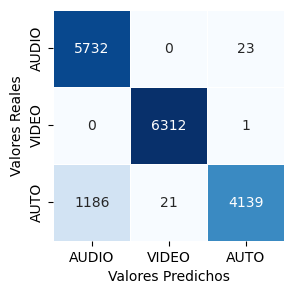

In [228]:
y_pred_RF = RF_model3.predict(x_test)
cm = metrics.confusion_matrix(y_test, y_pred_RF)
class_names = ['AUDIO', 'VIDEO', 'AUTO']

sns.heatmap(cm, annot = True, fmt = '0.0f', linewidth=0.5, xticklabels=class_names, 
            yticklabels=class_names, square = True, cmap='Blues', cbar = False)

fig = plt.gcf()
fig.set_size_inches(3, 3)

plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
plt.show()

In [229]:
print(metrics.classification_report(y_test, y_pred_RF))

                 precision    recall  f1-score   support

          AUDIO       0.83      1.00      0.90      5755
         CAMERA       1.00      1.00      1.00      6313
HOME AUTOMATION       0.99      0.77      0.87      5346

       accuracy                           0.93     17414
      macro avg       0.94      0.92      0.92     17414
   weighted avg       0.94      0.93      0.93     17414



# DECISION TREE

# Sin hiperparámetros

In [11]:
dt = DecisionTreeClassifier() #Instanciamos

start = time.time()
dt.fit(x_train, y_train)
stop = time.time()

In [12]:
print(f"Training time: {stop - start}s")
print(f'Train accuracy : {dt.score(x_train, y_train): .3f}')
print(f'Test accuracy : {dt.score(x_test, y_test): .3f}')

Training time: 0.4090301990509033s
Train accuracy :  1.000
Test accuracy :  0.908


## Matriz de confusión:

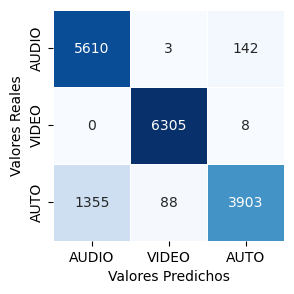

In [363]:
#Guardamos la predicción de Random Forest
y_pred_DT = dt.predict(x_test)
cm = metrics.confusion_matrix(y_test, y_pred_DT)
class_names = ['AUDIO', 'VIDEO', 'AUTO']

sns.heatmap(cm, annot = True, fmt = '0.0f', linewidth=0.5, xticklabels=class_names, 
            yticklabels=class_names, square = True, cmap='Blues', cbar = False)

fig = plt.gcf()
fig.set_size_inches(3, 3)

plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
plt.show()

In [233]:
print(metrics.classification_report(y_test, y_pred_DT))

                 precision    recall  f1-score   support

          AUDIO       0.81      0.97      0.88      5755
         CAMERA       0.99      1.00      0.99      6313
HOME AUTOMATION       0.96      0.73      0.83      5346

       accuracy                           0.91     17414
      macro avg       0.92      0.90      0.90     17414
   weighted avg       0.92      0.91      0.91     17414



# Definición de todos los hiperparámetros:

In [342]:
# Criterio de creación de los árboles. Es la función que mide la calidad de las "split".
criterion = ["gini", "entropy"]
#Para fijar la profundidad máxima de los árboles
max_depth = [int(x) for x in np.linspace(start=1, stop=10, num=10)] 
# Número de características a tener en cuenta para cada árbol
max_features = ['auto', 'sqrt', 'log2', None]
# Mínimo número de muestras que se requieren para dividir un nodo
min_samples_split = [int(x) for x in np.linspace(start=2, stop=10, num=9)]
# Mínimo número de muestras que se requieren en cada hoja
min_samples_leaf = [int(x) for x in np.linspace(start=1, stop=10, num=10)]
#Estrategia usada para dividir los nodos
splitter = ['best', 'random']

max_leaf_nodes = [int(x) for x in np.linspace(start=1, stop=40, num=40)]

In [343]:
param_grid3 = {'max_depth': max_depth,
              'criterion': criterion,
              'max_features': max_features,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'splitter': splitter}

DT_RandomGrid = RandomizedSearchCV(estimator = dt,
                                   param_distributions = param_grid3,
                                   cv = 5, verbose=2, n_jobs = 4)

start = time.time()
DT_RandomGrid.fit(x_train, y_train)
stop = time.time()

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [344]:
print(f"RandomizedSearch DT time: {stop - start}s")
print(f'Train accuracy : {DT_RandomGrid.score(x_train, y_train): .3f}')
print(f'Test accuracy : {DT_RandomGrid.score(x_test, y_test): .3f}')

RandomizedSearch DT time: 2.2838973999023438s
Train accuracy :  0.886
Test accuracy :  0.921


In [345]:
DT_RandomGrid.best_params_

{'splitter': 'random',
 'min_samples_split': 3,
 'min_samples_leaf': 5,
 'max_features': None,
 'max_depth': 7,
 'criterion': 'entropy'}

In [352]:
dt1 = DecisionTreeClassifier(criterion = 'entropy', 
                             splitter='random',
                             min_samples_split = 3, 
                             min_samples_leaf = 5,
                             max_depth = 7,
                             max_features = None)

start = time.time()
dt1.fit(x_train, y_train)
stop = time.time()

In [353]:
print(f"Training time: {stop - start}s")
print(f'Train accuracy : {dt1.score(x_train, y_train): .3f}')
print(f'Test accuracy : {dt1.score(x_test, y_test): .3f}')

Training time: 0.11988234519958496s
Train accuracy :  0.890
Test accuracy :  0.912


# Introduciendo parámetros manualmente:

In [140]:
#Sacamos los parámetros del árbol sin hiperparámetros, ya que nos ha salido con buena precisión.
dt.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

## Introducimos los parámetros obtenidos manualmente:

In [360]:
dt1 = DecisionTreeClassifier(criterion = 'gini', 
                             splitter='best',
                             min_samples_split = 60, 
                             min_samples_leaf = 20,
                             min_weight_fraction_leaf = 0.0,
                             min_impurity_decrease = 0.0,
                             class_weight = None,
                             random_state = None,
                             max_leaf_nodes = None,
                             max_depth = 7,
                             max_features = None,
                             ccp_alpha = 0.0) #Instanciamos

#60 20

In [361]:
start = time.time()
dt1.fit(x_train, y_train)
stop = time.time()

In [362]:
print(f"Training time: {stop - start}s")
print(f'Train accuracy : {dt1.score(x_train, y_train): .3f}')
print(f'Test accuracy : {dt1.score(x_test, y_test): .3f}')

Training time: 0.36929869651794434s
Train accuracy :  0.986
Test accuracy :  0.923


In [307]:
dt1.get_depth()

7

In [308]:
dt1.get_n_leaves()

38

## Matriz de confusión:

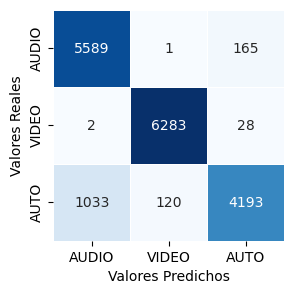

In [364]:
y_pred_DT1 = dt1.predict(x_test)
cm = metrics.confusion_matrix(y_test, y_pred_DT1)

class_names = ['AUDIO', 'VIDEO', 'AUTO']

sns.heatmap(cm, annot = True, fmt = '0.0f', linewidth=0.5, xticklabels=class_names, 
            yticklabels=class_names, square = True, cmap='Blues', cbar = False)

fig = plt.gcf()
fig.set_size_inches(3, 3)

plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
plt.show()

In [365]:
print(metrics.classification_report(y_test, y_pred_DT1))

                 precision    recall  f1-score   support

          AUDIO       0.84      0.97      0.90      5755
         CAMERA       0.98      1.00      0.99      6313
HOME AUTOMATION       0.96      0.78      0.86      5346

       accuracy                           0.92     17414
      macro avg       0.93      0.92      0.92     17414
   weighted avg       0.93      0.92      0.92     17414



In [366]:
feature_names = x_train.columns
feature_names

Index(['L4_tcp', 'L4_udp', 'L7_http', 'L7_https', 'port_class_src',
       'port_class_dst', 'pck_size', 'ethernet_frame_size', 'ttl',
       'total_length', 'protocol', 'DNS_count', 'NTP_count', 'ARP_count',
       'cnt', 'L3_ip_dst_count', 'most_freq_prot', 'sum_et', 'min_et',
       'max_et', 'med_et', 'average_et', 'skew_et', 'kurt_et', 'var', 'q3',
       'q1', 'iqr', 'sum_e', 'min_e', 'max_e', 'med', 'average', 'skew_e',
       'kurt_e', 'var_e', 'q3_e', 'q1_e', 'iqr_e', 'inter_arrival_time',
       'time_since_previously_displayed_frame'],
      dtype='object')

In [367]:
dt1.feature_importances_

array([0.00000000e+00, 2.03673708e-01, 0.00000000e+00, 0.00000000e+00,
       2.83052868e-02, 1.54480303e-02, 6.36510615e-04, 0.00000000e+00,
       7.25985362e-02, 2.14430517e-03, 0.00000000e+00, 2.53069489e-01,
       0.00000000e+00, 9.96133346e-04, 1.63053848e-02, 3.87826726e-01,
       2.65558461e-03, 0.00000000e+00, 1.06936016e-02, 1.50638972e-05,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.30216285e-05, 0.00000000e+00, 6.12805829e-05, 0.00000000e+00,
       5.01891075e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       4.35532251e-03, 1.45243735e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.37362072e-04,
       6.04390165e-04])

In [368]:
feature_importances = pd.DataFrame(dt1.feature_importances_, index = feature_names).sort_values(0, ascending = False)
feature_importances

,0
L3_ip_dst_count,0.387827
DNS_count,0.253069
L4_udp,0.203674
ttl,0.072599
port_class_src,0.028305
cnt,0.016305
port_class_dst,0.015448
min_et,0.010694
average,0.004355
most_freq_prot,0.002656


<AxesSubplot:>

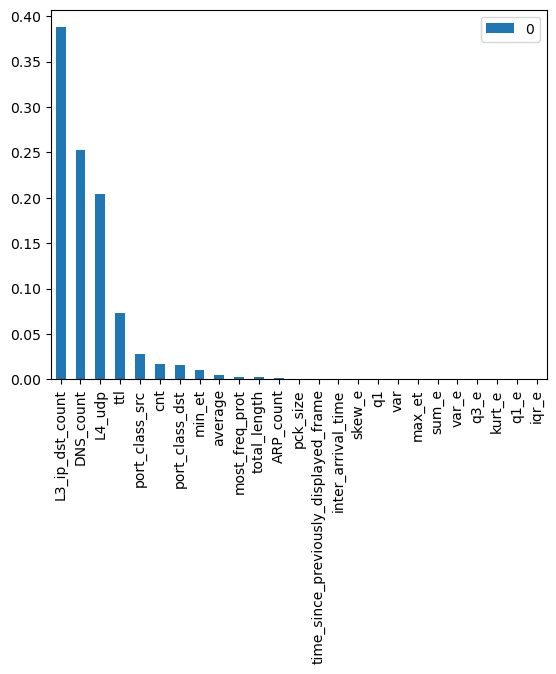

In [369]:
feature_importances.head(25).plot(kind='bar')

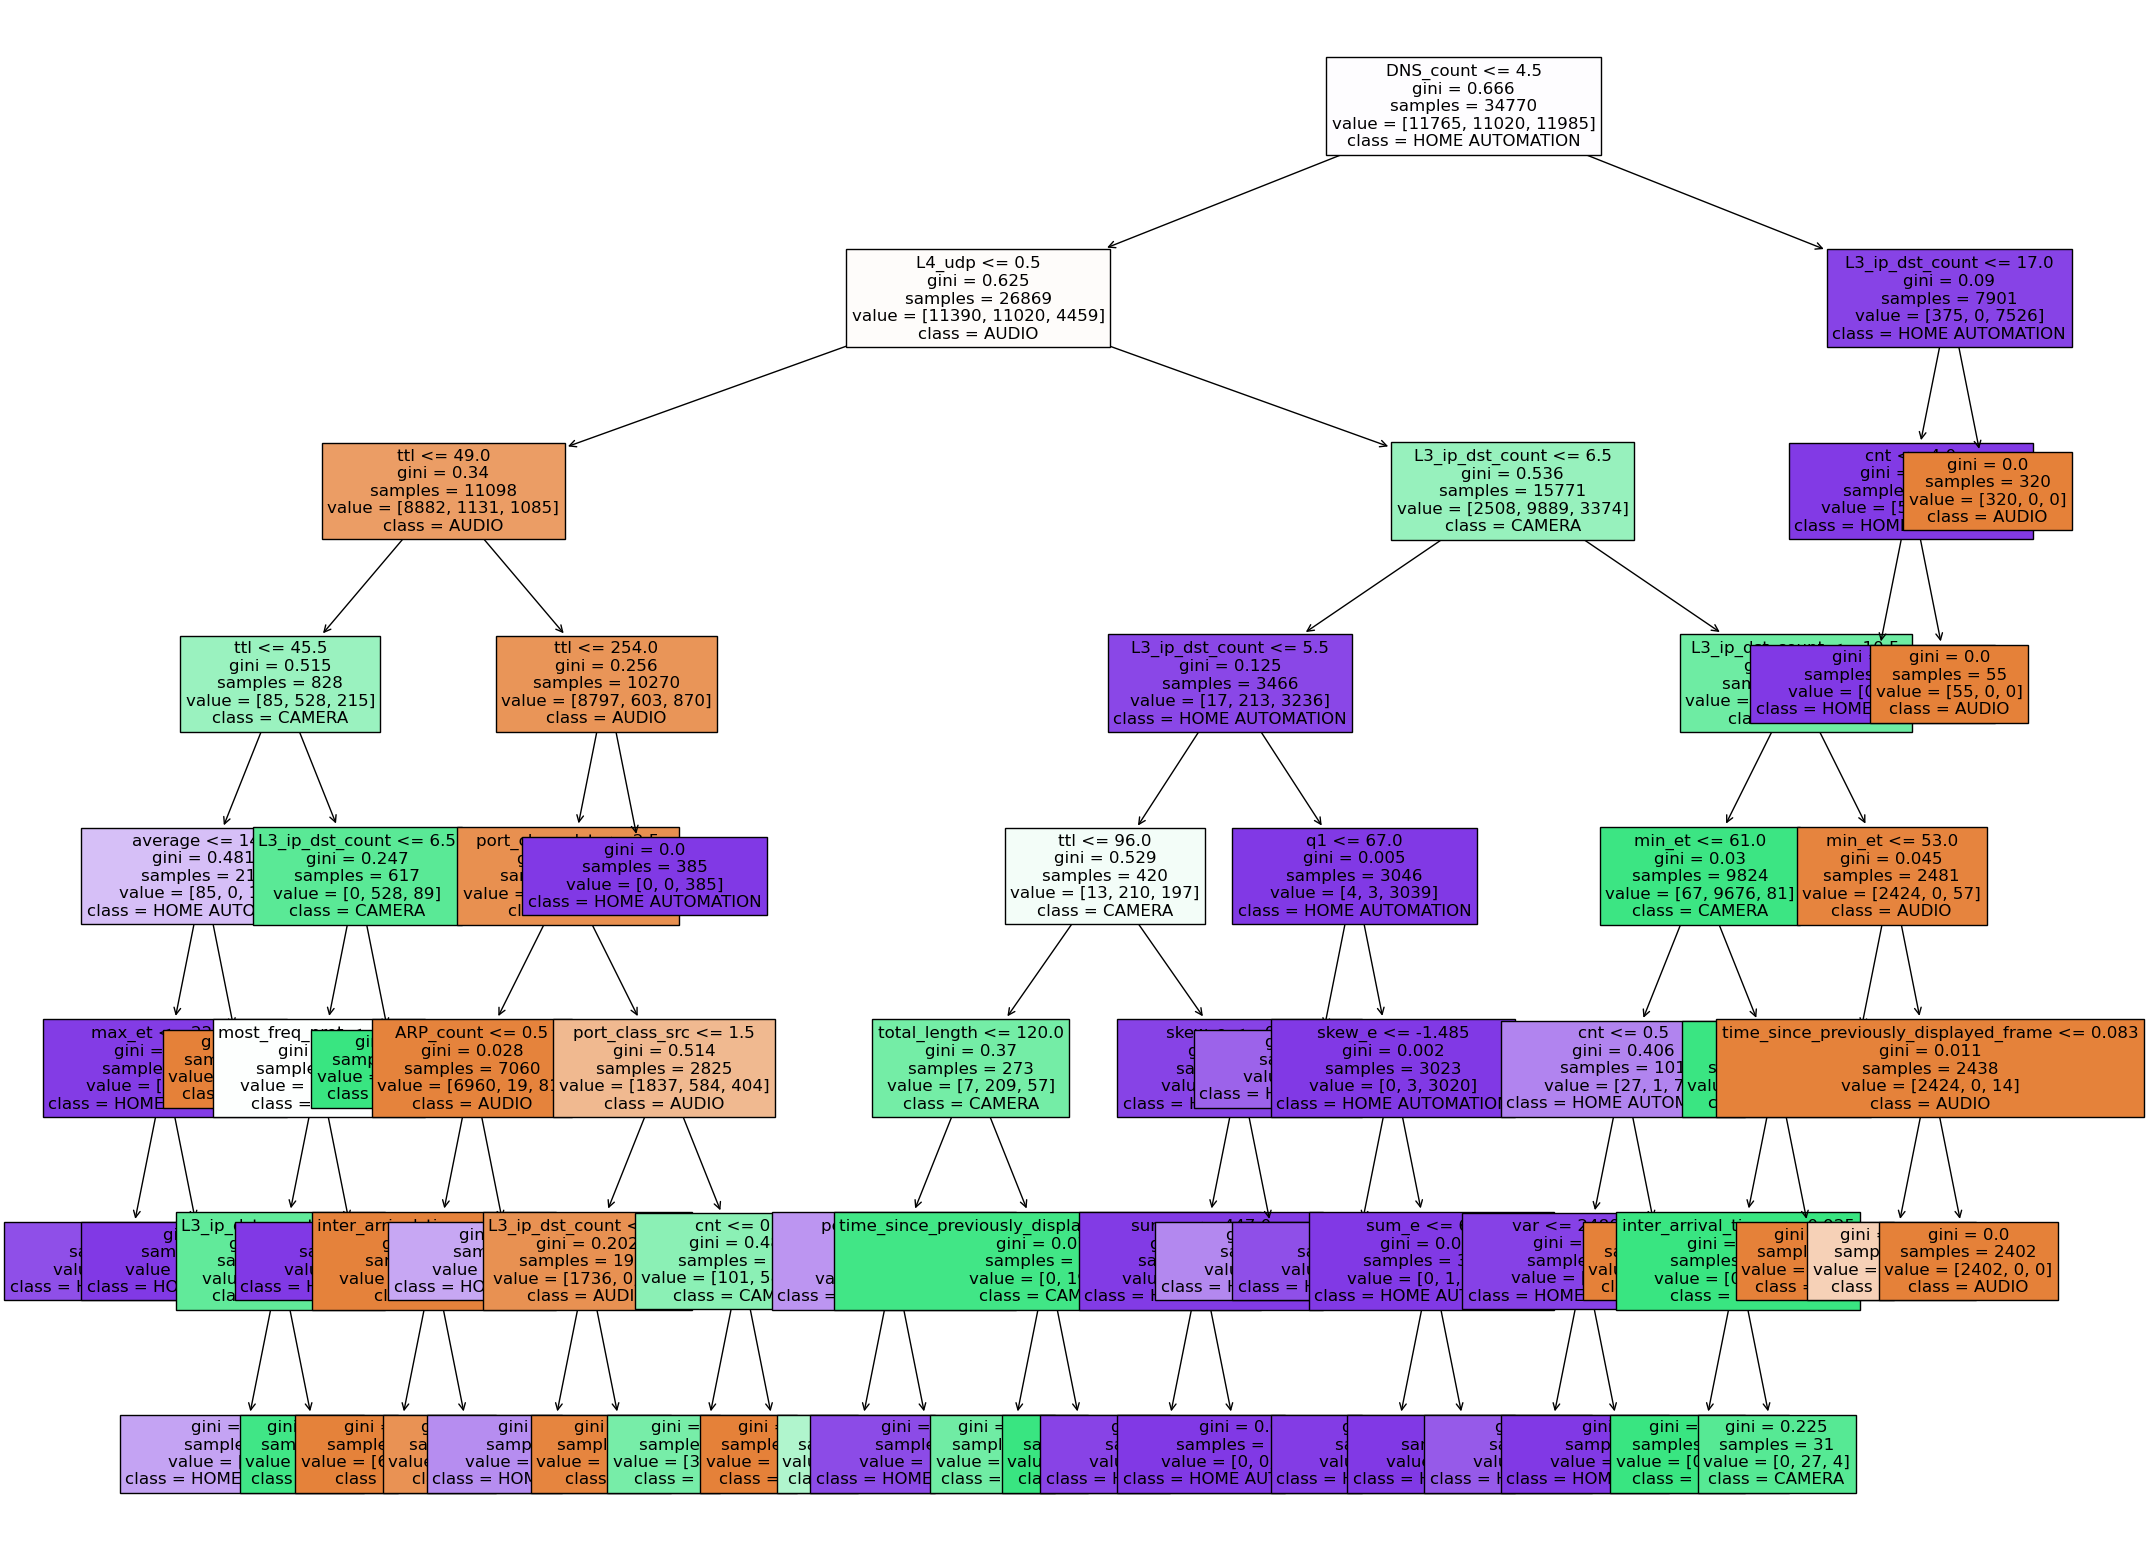

In [370]:
fig = plt.figure(figsize=(25,20))
tree = tree.plot_tree(dt1,
                      feature_names=feature_names,
                      class_names={0:'AUDIO', 1:'CAMERA', 2:'HOME AUTOMATION'},
                      filled = True,
                      fontsize = 12)

## Árbol de decisión con las 7 propiedades de mayor peso:

In [418]:
# Seleccionar las columnas deseadas
columnas_deseadas = ['L3_ip_dst_count', 'DNS_count', 'L4_udp','ttl', 'global_category']
train_nuevo = train[columnas_deseadas]
test_nuevo = test[columnas_deseadas]

In [419]:
train_nuevo

,L3_ip_dst_count,DNS_count,L4_udp,ttl,global_category
0,12,0,False,64,AUDIO
1,12,0,False,128,AUDIO
2,12,0,False,64,AUDIO
3,12,0,False,64,AUDIO
4,12,0,False,128,AUDIO
...,...,...,...,...,...
34765,9,0,False,255,HOME AUTOMATION
34766,9,0,False,0,HOME AUTOMATION
34767,9,0,False,229,HOME AUTOMATION
34768,9,0,False,229,HOME AUTOMATION


In [420]:
x_train_n, y_train_n = train_nuevo.drop(columns=['global_category']), train_nuevo['global_category']
x_test_n, y_test_n = test_nuevo.drop(columns=['global_category']), test_nuevo['global_category']

In [431]:
dt2 = DecisionTreeClassifier(criterion = 'gini', 
                             splitter='best',
                             min_samples_split = 60, 
                             min_samples_leaf = 20,
                             min_weight_fraction_leaf = 0.0,
                             min_impurity_decrease = 0.0,
                             class_weight = None,
                             max_leaf_nodes = None,
                             max_depth = 7,
                             max_features = None,
                             ccp_alpha = 0.0) #Instanciamos

start = time.time()
dt2.fit(x_train_n, y_train_n)
stop = time.time()

In [432]:
print(f"Training time: {stop - start}s")
print(f'Train accuracy : {dt2.score(x_train_n, y_train_n): .3f}')
print(f'Test accuracy : {dt2.score(x_test_n, y_test_n): .3f}')

Training time: 0.0538487434387207s
Train accuracy :  0.974
Test accuracy :  0.909


In [423]:
y_pred_DT2 = dt2.predict(x_test_n)
cm = metrics.confusion_matrix(y_test_n, y_pred_DT2)

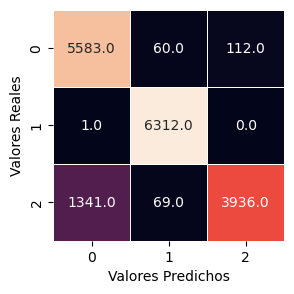

In [424]:
plt.figure(figsize=(3,3))
sns.heatmap(cm, annot = True, fmt = '0.1f', linewidth=0.5, 
            square = True, cbar = False)
plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
plt.show()

In [425]:
dt2.get_depth()

7

In [426]:
feature_names_n = x_train_n.columns
feature_names_n

Index(['L3_ip_dst_count', 'DNS_count', 'L4_udp', 'ttl'], dtype='object')

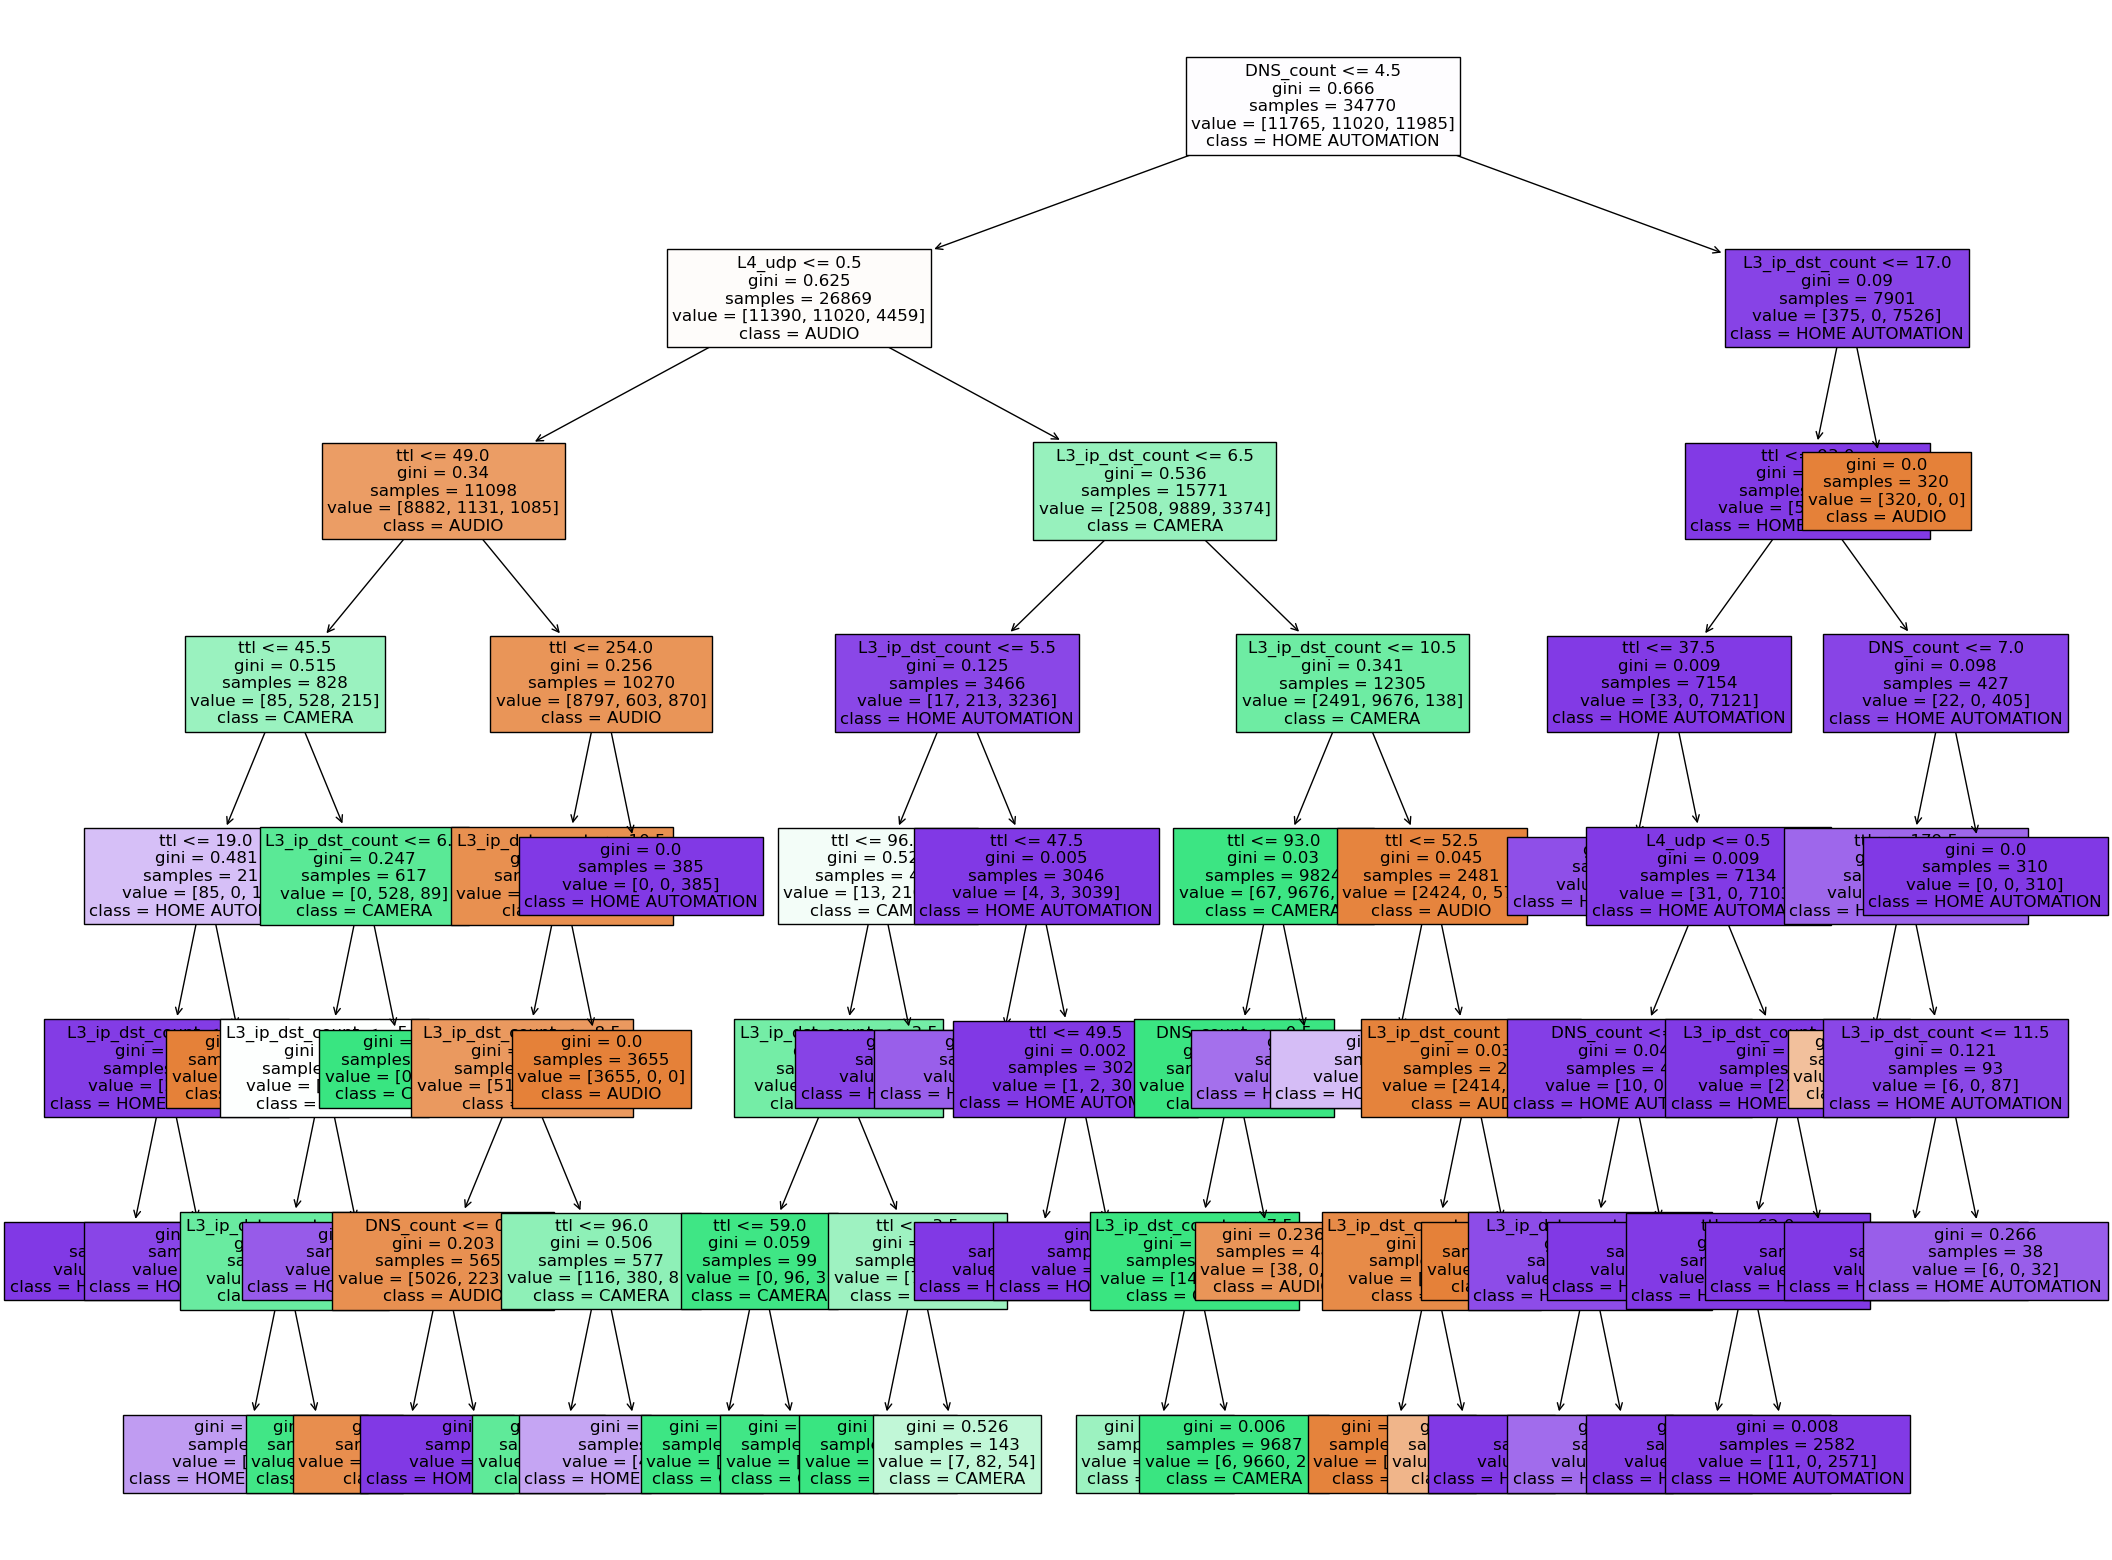

In [430]:
fig = plt.figure(figsize=(25,20))
tree = tree.plot_tree(dt2,
                      feature_names=feature_names_n,
                      class_names={0:'AUDIO', 1:'CAMERA', 2:'HOME AUTOMATION'},
                      filled = True,
                      fontsize = 12)